In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
import pandas as pd

df = pd.read_csv(r"exoplanet_catalogue.csv")
print(len(df))

# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

df_mr = df[['mass','radius','mass_error_min']].copy() # df with only mass and radius columns

c_df_mr = df_mr.dropna().copy()
print(len(c_df_mr))

r_df_mr = df_mr.dropna(subset=['radius']).copy() # all rows have radius
print(len(r_df_mr))
m_df_mr = df_mr.dropna(subset=['mass']).copy() # all rows have mass
print(len(m_df_mr))

# Set random seed for reproducibility
np.random.seed(42)

7408
1874
4964
4448


Running MCMC sampling...


 12%|█▏        | 121/1000 [00:27<02:52,  5.10it/s]C:\Users\arpan\AppData\Local\Temp\ipykernel_37692\31000211.py:29: RuntimeWarning: overflow encountered in exp
  rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))
100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]


Done!


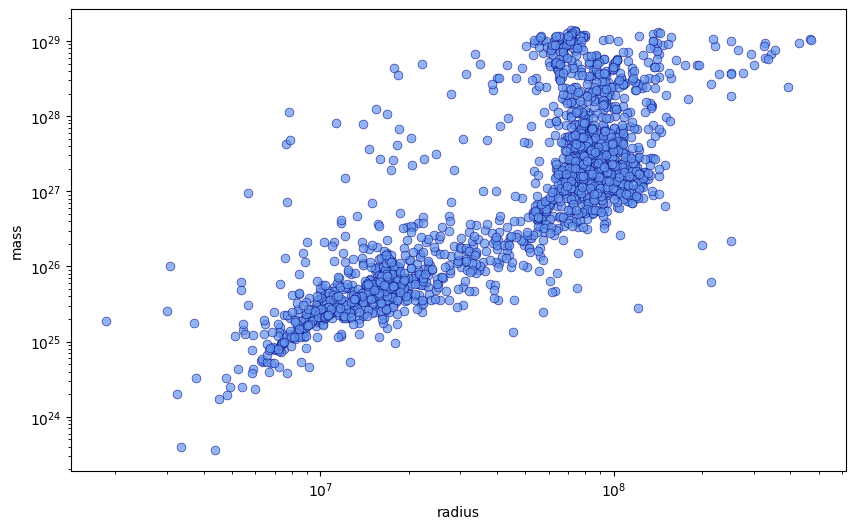

In [6]:
# c_df_mr is your dataframe with mass and radius data
x = np.array(c_df_mr["radius"])           * 7.149e+7 # converting to m
y = np.array(c_df_mr["mass"])             * 1.899e+27 # converting to kg
err = np.array(c_df_mr['mass_error_min']) * 1.899e+27 # converting to kg

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Create scatter plot with better aesthetics
scatter = plt.scatter(x, y, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5, label = 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass')

# standardizing the data
mu_x, mu_y, sig_x, sig_y = np.mean(x), np.mean(y), np.std(x), np.std(y)

x = (x-mu_x)/sig_x
y = (y-mu_y)/sig_y
err = (err-mu_y)/sig_y


def step_mass_model(radius, d_rocky, d_gas, threshold_radius, s_width = 1e-1):
    mass = []
    for i, r in enumerate(radius):
        r = r*sig_x + mu_x    
        # Calculate rocky mass
        rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))
        rocky_mass = (4/3 * np.pi * r**3) * d_rocky

        g_s = (4/3 * np.pi * r**3) * d_gas
        g_emp = 0

        gas_mass = g_s + g_emp
        # if i < 1:
        #     print(f" percentage from sphere {g_s/gas_mass * 100:4e} \t percentage from emperical {g_emp/gas_mass * 100:4e}")
        
        total_mass = rocky_weight * rocky_mass + (1 - rocky_weight) * gas_mass
        # if i < 1:
        #         print(f"  total_mass={total_mass:.3e} \n  real mass = {(y[i]*sig_y + mu_y):.3e}")

        total_mass = (total_mass - mu_y) / sig_y

        mass.append(total_mass)
    
    return np.array(mass)


# 2. Bayesian Model Definition with emcee

# Define the log prior function
def log_prior(params):
    d_rocky, d_gas, threshold_radius = params

    if not 1000 < d_rocky < 20000: # d_rocky: 1-20 g/cm³
        return -np.inf
    
    if not 100 < d_gas < 10000: # d_rocky: 1-20 g/cm³
        return -np.inf
    
    # If we get here, all parameters are within their priors
    return 0.0

# Define the log likelihood function
def log_likelihood(params, x, y):

    # Model prediction
    model = step_mass_model(x, *params)
    
    # Gaussian log likelihood
    return -0.5 * np.sum(((y - model) / err)**2 + np.log(2 * np.pi * err**2))

# Define the log posterior function
def log_posterior(params, x, y):

    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

# Perform MCMC sampling with emcee
def run_emcee_sampling(x, y, nwalkers=32, nsteps=5000, ndim=3):

    init_d_rocky = 5e3                     + np.random.randn(nwalkers) * 0.1 # 5 gm/cm^3 converted into kg/m^3
    init_d_gas = 1e3                       + np.random.randn(nwalkers) * 0.1 # 5 gm/cm^3 converted into kg/m^3
    init_threshold_radius = 2.5 * 6.3781e6 + np.random.randn(nwalkers) * 0.1 # 2 Earth radius converted into m
    
    initial_positions = np.column_stack([init_d_rocky,init_d_gas,init_threshold_radius])
    
    # Set up the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_posterior, args=(x, y)
    )
    
    # Run the sampler
    print("Running MCMC sampling...")
    sampler.run_mcmc(initial_positions, nsteps, progress=True)
    print("Done!")
    
    return sampler

# Run the emcee sampling
nwalkers = 32
nsteps = 1000
sampler = run_emcee_sampling(x, y, nwalkers=nwalkers, nsteps=nsteps)

C:\Users\arpan\AppData\Local\Temp\ipykernel_37692\749118639.py:11: RuntimeWarning: overflow encountered in exp
  sigma_samples = np.exp(log_sigma_samples)



Posterior Summary:
alpha: 18960.7426 ± 3412.0870
beta: 676.0192 ± 100.8641
sigma: inf ± nan

95% Credible Intervals:
alpha: [5614.9212, 19999.9558]
beta: [624.4976, 952.2117]
sigma: [nan, nan]


C:\Users\arpan\AppData\Local\Temp\ipykernel_37692\749118639.py:55: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(sampler.get_chain()[..., 2].T), 'k-', alpha=0.3)


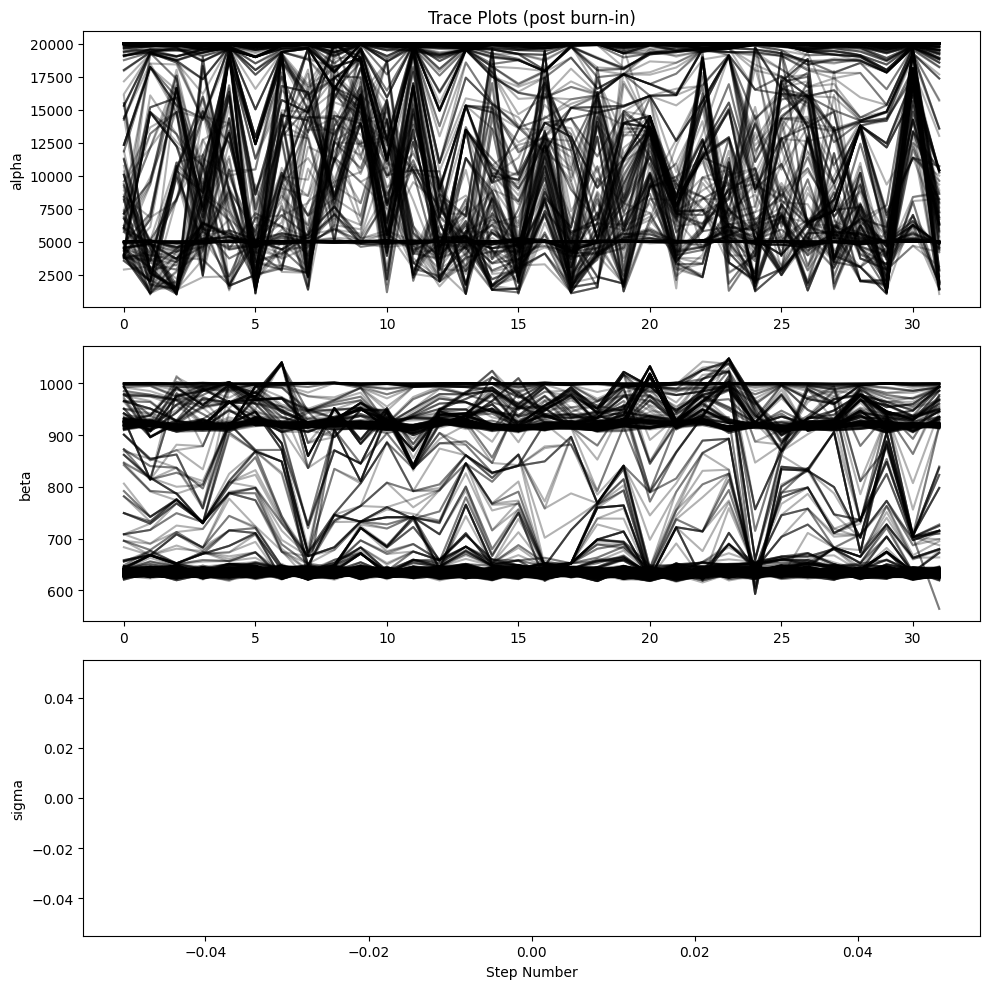

ValueError: It looks like the parameter(s) in column(s) 2 have no dynamic range. Please provide a `range` argument.

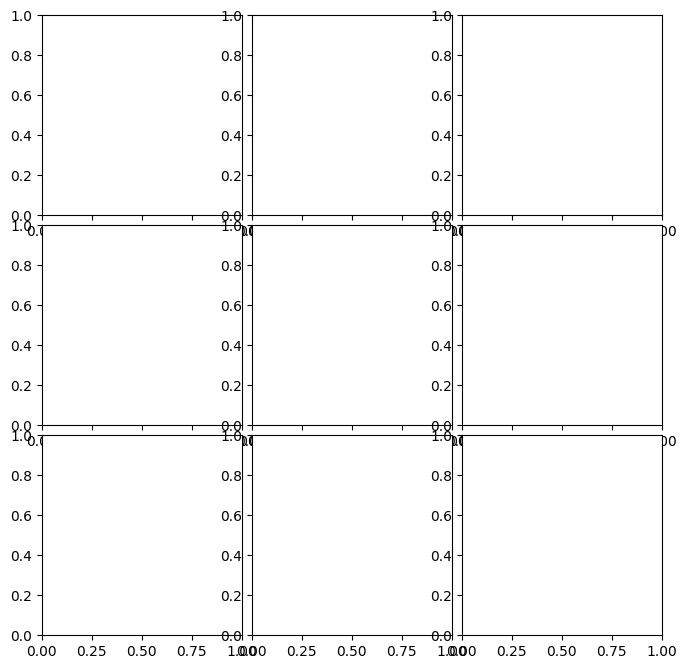

In [7]:
# 3. Analyze Results

# Burn-in: discard the first 1000 steps
burn_in = 100
samples = sampler.get_chain(discard=burn_in, flat=True)

# Extract the parameters
alpha_samples = samples[:, 0]
beta_samples = samples[:, 1]
log_sigma_samples = samples[:, 2]
sigma_samples = np.exp(log_sigma_samples)

# Calculate statistics from the samples
alpha_mean = np.mean(alpha_samples)
alpha_std = np.std(alpha_samples)
beta_mean = np.mean(beta_samples)
beta_std = np.std(beta_samples)
sigma_mean = np.mean(sigma_samples)
sigma_std = np.std(sigma_samples)

# Print summary statistics
print("\nPosterior Summary:")
print(f"alpha: {alpha_mean:.4f} ± {alpha_std:.4f}")
print(f"beta: {beta_mean:.4f} ± {beta_std:.4f}")
print(f"sigma: {sigma_mean:.4f} ± {sigma_std:.4f}")

# Calculate 95% credible intervals
alpha_interval = np.percentile(alpha_samples, [2.5, 97.5])
beta_interval = np.percentile(beta_samples, [2.5, 97.5])
sigma_interval = np.percentile(sigma_samples, [2.5, 97.5])

print("\n95% Credible Intervals:")
print(f"alpha: [{alpha_interval[0]:.4f}, {alpha_interval[1]:.4f}]")
print(f"beta: [{beta_interval[0]:.4f}, {beta_interval[1]:.4f}]")
print(f"sigma: [{sigma_interval[0]:.4f}, {sigma_interval[1]:.4f}]")

# Plot the trace plots to check convergence
plt.figure(figsize=(10, 10))

# Plot alpha traces
plt.subplot(3, 1, 1)
plt.plot(sampler.get_chain()[..., 0].T, 'k-', alpha=0.3)
# plt.axhline(true_alpha, color='r')
plt.ylabel('alpha')
plt.title('Trace Plots (post burn-in)')

# Plot beta traces
plt.subplot(3, 1, 2)
plt.plot(sampler.get_chain()[..., 1].T, 'k-', alpha=0.3)
# plt.axhline(true_beta, color='r')
plt.ylabel('beta')

# Plot sigma traces
plt.subplot(3, 1, 3)
plt.plot(np.exp(sampler.get_chain()[..., 2].T), 'k-', alpha=0.3)
# plt.axhline(true_sigma, color='r')
plt.ylabel('sigma')
plt.xlabel('Step Number')

plt.tight_layout()
plt.show()

# Plot the corner plot (joint posterior distributions)
labels = [r"$\alpha$", r"$\beta$", r"$\sigma$"]
fig = corner.corner(
    np.column_stack([alpha_samples, beta_samples, sigma_samples]),
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  # 16th, 50th, 84th percentiles
    # truths=[true_alpha, true_beta, true_sigma],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.tight_layout()
plt.show()

# 4. Plot regression line with uncertainty
# Number of posterior lines to plot
n_lines = 100

# Create figure
plt.figure(figsize=(10, 6))

# Plot original data
plt.scatter(x, y, color='blue', alpha=0.6, label='Observed Data')

# Plot posterior regression lines
x_pred = np.linspace(-1, 11, 100)
for i in range(n_lines):
    # Randomly select a sample from the posterior
    idx = np.random.randint(0, len(alpha_samples))
    alpha_sample = alpha_samples[idx]
    beta_sample = beta_samples[idx]
    
    # Calculate the regression line
    y_pred = alpha_sample + beta_sample * x_pred
    
    # Plot the line with low alpha for transparency
    plt.plot(x_pred, y_pred, 'green', alpha=0.05)

# Calculate the mean posterior regression line
y_pred_mean = alpha_mean + beta_mean * x_pred

# Plot the mean posterior regression line
plt.plot(x_pred, y_pred_mean, 'red', linewidth=2, label=f'Mean Posterior: y = {alpha_mean:.2f} + {beta_mean:.2f}x')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 5. Posterior Predictive Checks

# Number of samples to use for posterior predictive check
n_samples_ppc = 1000

# Generate predictions from posterior samples
y_ppc = np.zeros((n_samples_ppc, len(x)))

for i in range(n_samples_ppc):
    # Randomly select a sample from the posterior
    idx = np.random.randint(0, len(alpha_samples))
    alpha_sample = alpha_samples[idx]
    beta_sample = beta_samples[idx]
    sigma_sample = sigma_samples[idx]
    
    # Calculate the mean
    mean = alpha_sample + beta_sample * x
    
    # Generate random samples from the predicted distribution
    y_ppc[i] = np.random.normal(mean, sigma_sample)

# Plot posterior predictive checks
plt.figure(figsize=(10, 6))

# Plot original data
plt.scatter(x, y_observed, color='blue', label='Observed Data')

# Plot posterior predictive samples
for i in range(30):  # Plot 30 random posterior predictive samples
    plt.plot(x, y_ppc[i], 'g-', alpha=0.1)

# Plot the 5th and 95th percentiles of the posterior predictive distribution
y_ppc_5 = np.percentile(y_ppc, 5, axis=0)
y_ppc_95 = np.percentile(y_ppc, 95, axis=0)
plt.fill_between(x, y_ppc_5, y_ppc_95, color='gray', alpha=0.3, label='90% Prediction Interval')

# Plot the true regression line
plt.plot(x, true_alpha + true_beta * x, 'r--', label='True Line')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior Predictive Check')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Bayesian Credible Intervals for Predictions

# Generate predictions for new x values
x_new = np.linspace(-2, 12, 100)

# Number of posterior samples to use
n_samples_ci = 1000

# Initialize arrays to store predictions
y_pred_samples = np.zeros((n_samples_ci, len(x_new)))
y_pred_with_noise = np.zeros((n_samples_ci, len(x_new)))

# Generate predictions
for i in range(n_samples_ci):
    # Randomly select a sample from the posterior
    idx = np.random.randint(0, len(alpha_samples))
    alpha_sample = alpha_samples[idx]
    beta_sample = beta_samples[idx]
    sigma_sample = sigma_samples[idx]
    
    # Predicted means
    y_mean = alpha_sample + beta_sample * x_new
    y_pred_samples[i] = y_mean
    
    # Predicted values with noise
    y_pred_with_noise[i] = np.random.normal(y_mean, sigma_sample)

# Calculate statistics for the predictions
y_pred_mean = np.mean(y_pred_samples, axis=0)
y_pred_5 = np.percentile(y_pred_samples, 5, axis=0)
y_pred_95 = np.percentile(y_pred_samples, 95, axis=0)

# Calculate prediction intervals (includes uncertainty in parameters AND data noise)
y_interval_5 = np.percentile(y_pred_with_noise, 5, axis=0)
y_interval_95 = np.percentile(y_pred_with_noise, 95, axis=0)

# Plot mean and credible intervals for the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y_observed, color='blue', alpha=0.6, label='Observed Data')

# Plot the mean prediction
plt.plot(x_new, y_pred_mean, 'r-', label='Mean Posterior Prediction')

# Plot the 90% credible interval for the regression line
plt.fill_between(x_new, y_pred_5, y_pred_95, color='red', alpha=0.3, 
                 label='90% Credible Interval (Model)')

# Plot the 90% prediction interval (includes data noise)
plt.fill_between(x_new, y_interval_5, y_interval_95, color='green', alpha=0.15,
                label='90% Prediction Interval (with Noise)')

# Add the true line for comparison
plt.plot(x_new, true_alpha + true_beta * x_new, 'k--', label='True Line')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Credible Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Compare with Frequentist Approach
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit using scikit-learn (frequentist approach)
X = x.reshape(-1, 1)
freq_model = LinearRegression().fit(X, y_observed)
freq_intercept = freq_model.intercept_
freq_slope = freq_model.coef_[0]
freq_pred = freq_model.predict(X)

# Calculate frequentist metrics
freq_mse = mean_squared_error(y_observed, freq_pred)
freq_r2 = r2_score(y_observed, freq_pred)

# Calculate frequentist standard errors
n = len(x)
p = 2  # Number of parameters (intercept and slope)
y_hat = freq_pred
sse = np.sum((y_observed - y_hat) ** 2)
mse = sse / (n - p)
se = np.sqrt(mse)

# Calculate standard errors for parameters
X_with_intercept = np.column_stack([np.ones(n), x])
cov = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * mse
se_intercept = np.sqrt(cov[0, 0])
se_slope = np.sqrt(cov[1, 1])

# Print frequentist results
print("\nFrequentist Linear Regression:")
print(f"Intercept: {freq_intercept:.4f} ± {se_intercept:.4f}")
print(f"Slope: {freq_slope:.4f} ± {se_slope:.4f}")
print(f"Residual Standard Error: {se:.4f}")
print(f"MSE: {freq_mse:.4f}")
print(f"R²: {freq_r2:.4f}")

# Print Bayesian results again for comparison
print("\nBayesian Linear Regression:")
print(f"Intercept (mean): {alpha_mean:.4f} ± {alpha_std:.4f}")
print(f"Slope (mean): {beta_mean:.4f} ± {beta_std:.4f}")
print(f"Noise σ (mean): {sigma_mean:.4f} ± {sigma_std:.4f}")

# Compare the parameter estimates
print("\nParameter Comparison (True vs Bayesian vs Frequentist):")
print(f"Intercept: {true_alpha:.4f} (true) vs {alpha_mean:.4f} (Bayesian) vs {freq_intercept:.4f} (frequentist)")
print(f"Slope: {true_beta:.4f} (true) vs {beta_mean:.4f} (Bayesian) vs {freq_slope:.4f} (frequentist)")
print(f"Sigma: {true_sigma:.4f} (true) vs {sigma_mean:.4f} (Bayesian)")

# Create a visualization comparing the approaches
plt.figure(figsize=(12, 6))
plt.scatter(x, y_observed, color='blue', alpha=0.6, label='Observed Data')

# Plot the true line
plt.plot(x_new, true_alpha + true_beta * x_new, 'k-', linewidth=2, label='True Line')

# Plot the Bayesian regression line with uncertainty
plt.plot(x_new, y_pred_mean, 'r-', linewidth=2, label='Bayesian Regression')
plt.fill_between(x_new, y_pred_5, y_pred_95, color='red', alpha=0.2, label='90% Bayesian CI')

# Plot the frequentist regression line
plt.plot(x_new, freq_intercept + freq_slope * x_new, 'g--', linewidth=2, label='Frequentist Regression')

# Calculate frequentist confidence intervals (95%)
t_value = stats.t.ppf(0.975, n - p)  # Two-tailed 95% confidence
x_new_with_intercept = np.column_stack([np.ones(len(x_new)), x_new])
y_freq_mean = x_new_with_intercept @ np.array([freq_intercept, freq_slope])

# Standard errors for the predictions
se_pred = np.zeros(len(x_new))
for i, xi in enumerate(x_new):
    xi_with_intercept = np.array([1, xi])
    se_pred[i] = np.sqrt(mse * (xi_with_intercept @ cov @ xi_with_intercept))

# Confidence intervals
y_freq_lower = y_freq_mean - t_value * se_pred
y_freq_upper = y_freq_mean + t_value * se_pred

# Plot frequentist confidence interval
plt.fill_between(x_new, y_freq_lower, y_freq_upper, color='green', alpha=0.1, label='95% Frequentist CI')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison: Bayesian vs Frequentist Linear Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For the autocorrelation section, replace the problematic section with this code:

# 8. MCMC Diagnostics - Fixed version
plt.figure(figsize=(12, 8))
max_lag = 100

# Calculate autocorrelation for each parameter manually
for i, (param, name) in enumerate(zip(range(3), ['alpha', 'beta', 'log_sigma'])):
    plt.subplot(3, 1, i + 1)
    
    # Get the chains for this parameter
    chains = sampler.get_chain(discard=burn_in, flat=False)[:, :, param]
    
    # Calculate autocorrelation manually
    mean_chains = np.mean(chains, axis=(0, 1))
    chain_anomalies = chains - mean_chains
    
    # Compute autocorrelation for each walker and average
    acorrs = []
    for walker in range(chains.shape[1]):
        walker_chain = chain_anomalies[:, walker]
        
        # Normalize
        norm = np.sum(walker_chain**2)
        
        # Calculate autocorrelation through NumPy's correlate
        acorr = np.correlate(walker_chain, walker_chain, mode='full')
        acorr = acorr[acorr.size//2:] # Take only the second half
        acorr = acorr[:max_lag]  # Limit to max_lag
        acorr = acorr / norm  # Normalize
        
        acorrs.append(acorr)
    
    # Average across walkers
    avg_acorr = np.mean(acorrs, axis=0)
    
    plt.plot(avg_acorr)
    plt.title(f'Autocorrelation: {name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)

plt.tight_layout()
plt.show()

# For the integrated autocorrelation time and effective sample size calculation,
# check if the function exists before using it
try:
    # Try using the emcee function if available
    tau = emcee.autocorr.integrated_time(sampler.get_chain(discard=burn_in, flat=False))
    neff = np.zeros(3)
    for i in range(3):
        neff[i] = sampler.get_chain(discard=burn_in, flat=False).shape[0] * nwalkers / tau[i]
    
    print("\nEffective Sample Size:")
    print(f"alpha: {neff[0]:.1f}")
    print(f"beta: {neff[1]:.1f}")
    print(f"log_sigma: {neff[2]:.1f}")
    
except (AttributeError, ImportError):
    # If that fails, use a simpler estimate
    print("\nCould not calculate integrated autocorrelation time with emcee.")
    print("Using simple estimate instead.")
    
    # Simple estimate: effective samples ≈ total samples / 50
    # (this is very rough and assumes an autocorrelation time of about 50 steps)
    n_total = len(samples)
    print(f"Total samples: {n_total}")
    print(f"Rough effective sample size estimate: {n_total/50:.1f} per parameter")

# Calculate the effective sample size
tau = emcee.autocorr.integrated_time(sampler.get_chain(discard=burn_in, flat=False))
neff = np.zeros(3)
for i in range(3):
    neff[i] = sampler.get_chain(discard=burn_in, flat=False).shape[0] * nwalkers / tau[i]

print("\nEffective Sample Size:")
print(f"alpha: {neff[0]:.1f}")
print(f"beta: {neff[1]:.1f}")
print(f"log_sigma: {neff[2]:.1f}")